# LendingClub Loan Prediction - Model Evaluation
## Author: Congjun Huang

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import palettable
import pickle

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read best model pickle
with open('best_model.pickle', 'rb') as file:
    best_model = pickle.load(file)

In [3]:
# get training and test data
X_train = pd.read_csv('X_train.csv')
X_train.index = X_train['Unnamed: 0']
X_train = X_train.drop(['Unnamed: 0'], axis=1)
X_train.index.name = ''

y_train = pd.read_csv('y_train.csv')
y_train.index = y_train['Unnamed: 0']
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_train.index.name = ''

X_test = pd.read_csv('X_test.csv')
X_test.index = X_test['Unnamed: 0']
X_test = X_test.drop(['Unnamed: 0'], axis=1)
X_test.index.name = ''

y_test = pd.read_csv('y_test.csv')
y_test.index = y_test['Unnamed: 0']
y_test = y_test.drop(['Unnamed: 0'], axis=1)
y_test.index.name = ''

In [4]:
# retrain best model on training data
final_model = best_model.fit(X_train, y_train)

In [5]:
# compare to baseline model
baseline_model = sm.GLM(y_train, X_train, family=sm.families.Binomial(), missing='drop')
res = baseline_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            loan_status   No. Observations:               108742
Model:                            GLM   Df Residuals:                   108702
Model Family:                Binomial   Df Model:                           39
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -67885.
Date:                Tue, 16 Aug 2022   Deviance:                   1.3577e+05
Time:                        15:06:43   Pearson chi2:                 1.99e+10
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
ho

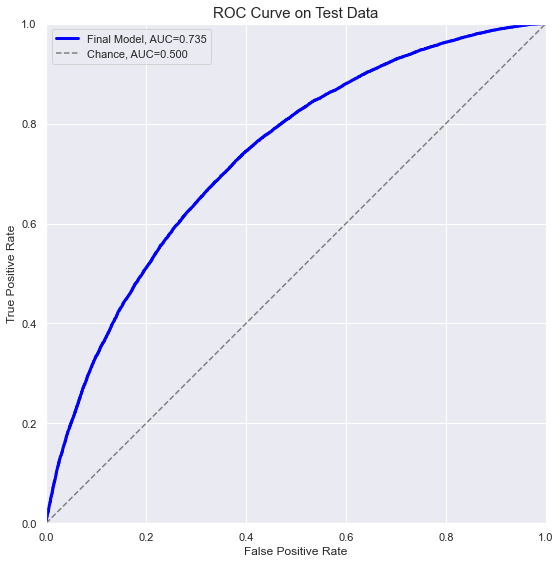

In [6]:
# apply final model to test data 
# plot ROC curve 
plt.figure(figsize=(12,8))

# plot ROC curve
y_pred = final_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', linestyle='-', linewidth=3, label='Final Model, AUC={:.3f}'.format(roc_auc))

# plot the chance diagonal
plt.plot((0,1), (0,1), color='grey', linestyle='--', label='Chance, AUC=0.500')

# add elements to the plot
plt.axis('square')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve on Test Data', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

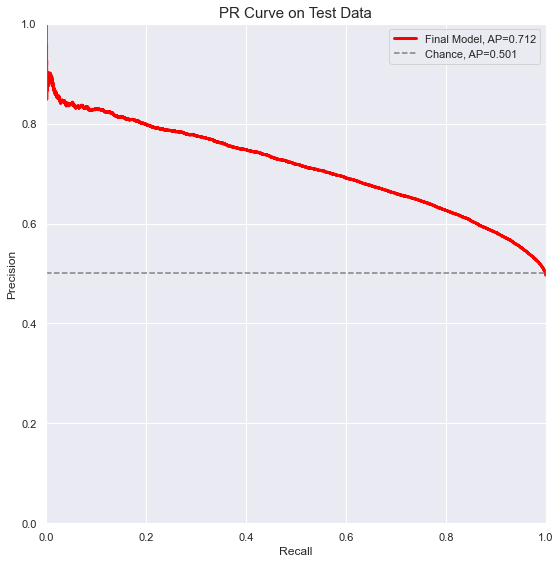

In [7]:
# apply final model to test data 
# plot PR curve 
plt.figure(figsize=(12,8))

# plot PR curve
y_pred = final_model.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)
plt.plot(recall, precision, color='red', linestyle='-', linewidth=3, label='Final Model, AP={:.3f}'.format(ap))

# plot the chance line
frac = len(np.where(y_train==1)[0])/y_train.shape[0]
plt.plot((0,1), (frac,frac), color='grey', linestyle='--', label='Chance, AP={:.3f}'.format(frac))

# add elements to the plot
plt.axis('square')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('PR Curve on Test Data', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()

[Text(0, 0.5, 'Fully Paid'), Text(0, 1.5, 'Charged Off')]

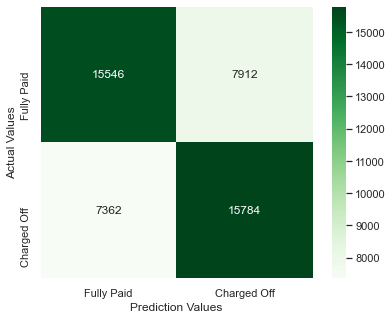

In [8]:
# apply final model to test data 
# create a confusion matrix with actual numbers
y_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
ax = sns.heatmap(cm, fmt='d', annot=True, square=True, cmap='Greens')

ax.set_xlabel('Prediction Values')
ax.set_ylabel('Actual Values');
ax.xaxis.set_ticklabels(['Fully Paid','Charged Off'])
ax.yaxis.set_ticklabels(['Fully Paid','Charged Off'])

[Text(0, 0.5, 'Fully Paid'), Text(0, 1.5, 'Charged Off')]

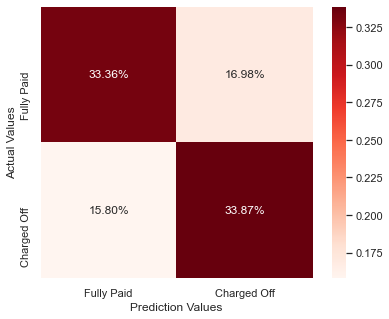

In [9]:
# apply final model to test data 
# create a confusion matrix with percentage
y_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
ax = sns.heatmap(cm/np.sum(cm), fmt='.2%', annot=True, square=True, cmap='Reds')

ax.set_xlabel('Prediction Values')
ax.set_ylabel('Actual Values');
ax.xaxis.set_ticklabels(['Fully Paid','Charged Off'])
ax.yaxis.set_ticklabels(['Fully Paid','Charged Off'])

In [10]:
# apply final model to test data 
# create a dataframe to show metrics
tpr = cm[1][1]/cm.sum(axis=1)[1]
fpr = cm[0][1]/cm.sum(axis=1)[0]
tnr = cm[0][0]/cm.sum(axis=1)[0]
fnr = cm[1][0]/cm.sum(axis=1)[1]
precision = cm[1][1]/cm.sum(axis=0)[1]
acc = (cm[0][0]+cm[1][1])/cm.sum()

metrics = [[tpr],[fpr],[tnr],[fnr],[precision],[acc]]
metrics_df = pd.DataFrame(metrics, columns=['Value'], index=['True Positive Rate', 'False Positive Rate',
                                                             'True Negative Rate', 'False Negative Rate',
                                                             'Precision', 'Accuracy'])

metrics_df

,Value
True Positive Rate,0.681932
False Positive Rate,0.337284
True Negative Rate,0.662716
False Negative Rate,0.318068
Precision,0.666104
Accuracy,0.672260
